In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import random
from collections import defaultdict

In [2]:
try:
    event_df = pd.read_csv('../dataset/events_processed.csv')
    item_df = pd.read_csv('../dataset/item_properties_processed.csv')
    category_df = pd.read_csv('../dataset/category_tree.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("❌ File not found. Please check the path.")
    

Data Loaded Successfully!


## Overview

#### Events

In [3]:
display(event_df.head())
print(event_df.info())
print(event_df[['event']].value_counts())
event_df.describe()


,timestamp,visitorid,event,itemid,transactionid,ISO datetime,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
 5   ISO datetime   object 
 6   date           object 
dtypes: float64(1), int64(3), object(3)
memory usage: 147.2+ MB
None
event      
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [5]:
# print(event_df['ISO datetime'].max()-event_df['ISO datetime'].min())
print(event_df['ISO datetime'].min())
print(event_df['ISO datetime'].max())

2015-05-03 03:00:04.384
2015-09-18 02:59:47.788


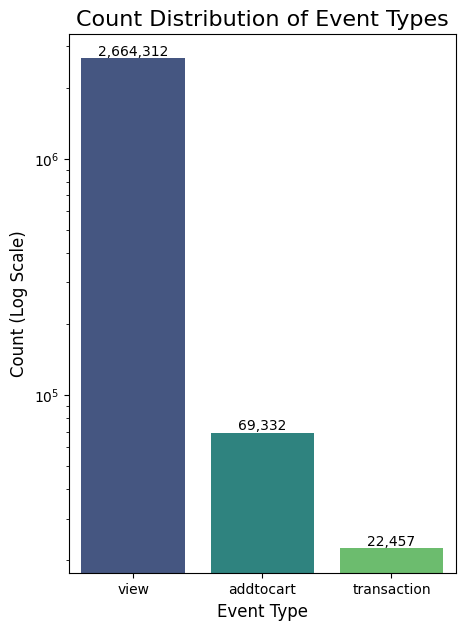

In [6]:
event_counts = event_df['event'].value_counts()

plt.figure(figsize=(5, 7)) 
sns.barplot(x=event_counts.index, y=event_counts.values,
            hue=event_counts.index,   # Assign x-variable to hue
            legend=False,             
            palette="viridis")

plt.title('Count Distribution of Event Types', fontsize=16)
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.yscale('log')

for i, count in enumerate(event_counts.values):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom')

plt.show()

In [7]:
# distribution các items được view/add-to-cart/ transaction theo khoảng ...
item_event_counts = (
    event_df.groupby(['event', 'itemid'])
      .size()
      .reset_index(name='count')
)
item_event_counts.max()

event       view
itemid    466867
count       3410
dtype: object

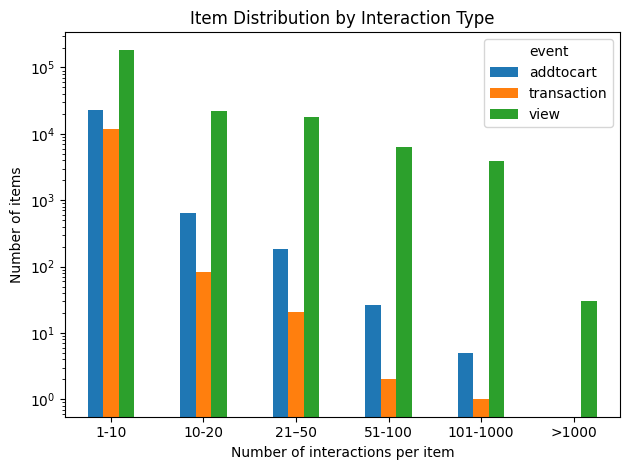

In [8]:
bins = [0, 10, 20, 50, 100, 1000, float('inf')]
labels = ['1-10','10-20', '21–50', '51-100', '101-1000', '>1000']

item_event_counts['count_bin'] = pd.cut(
    item_event_counts['count'],
    bins=bins,
    labels=labels
)
distribution = (
    item_event_counts
        .groupby(['event', 'count_bin'])
        .size()
        .unstack(fill_value=0)
)
distribution.T.plot(kind='bar')

plt.xlabel('Number of interactions per item')
plt.ylabel('Number of items')
plt.yscale('log')
plt.title('Item Distribution by Interaction Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

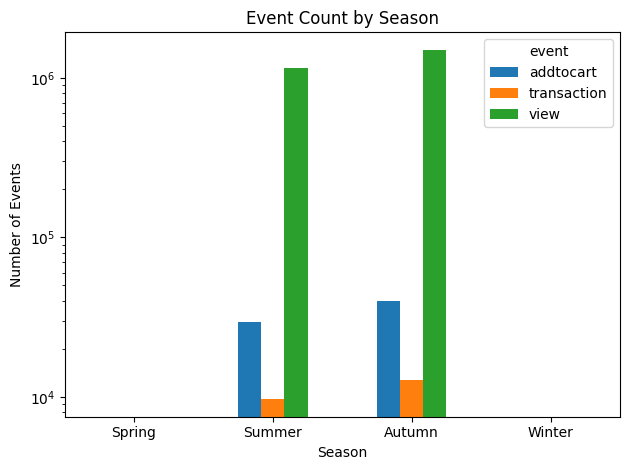

In [9]:
# đếm events theo mùa/tháng
event_df['ISO datetime'] = pd.to_datetime(event_df['ISO datetime'])

# Lấy tháng
event_df['month'] = event_df['ISO datetime'].dt.month

# Hàm xác định mùa
def get_season(month):
    if month in [1,2,3]:
        return 'Spring'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Autumn'
    else:
        return 'Winter'

# Tạo cột season
event_df['season'] = event_df['month'].apply(get_season)

# Đếm số event theo mùa
season_event_counts = (
    event_df.groupby(['season', 'event'])
      .size()
      .unstack(fill_value=0)
)

# Sắp xếp thứ tự mùa
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_event_counts = season_event_counts.reindex(season_order)

# Vẽ bar chart
season_event_counts.plot(kind='bar')

plt.xlabel('Season')
plt.ylabel('Number of Events')
plt.yscale('log')
plt.title('Event Count by Season')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Item_properties

In [10]:
display(item_df.head())
print(item_df.info())
# print(item_df[['property']].value_counts())
item_df.describe()


,timestamp,itemid,property,value,ISO datetime,date
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00,2015-06-28
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00,2015-09-06
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00,2015-08-09
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
4,1431831600000,156781,917,828513,2015-05-17 03:00:00,2015-05-17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   timestamp     int64 
 1   itemid        int64 
 2   property      object
 3   value         object
 4   ISO datetime  object
 5   date          object
dtypes: int64(2), object(4)
memory usage: 928.2+ MB
None


,timestamp,itemid
count,2.027590e+07,2.027590e+07
mean,1.435157e+12,2.333904e+05
std,3.327798e+09,1.348452e+05
min,1.431227e+12,0.000000e+00
25%,1.432436e+12,1.165160e+05
50%,1.433646e+12,2.334830e+05
75%,1.437880e+12,3.503040e+05
max,1.442113e+12,4.668660e+05


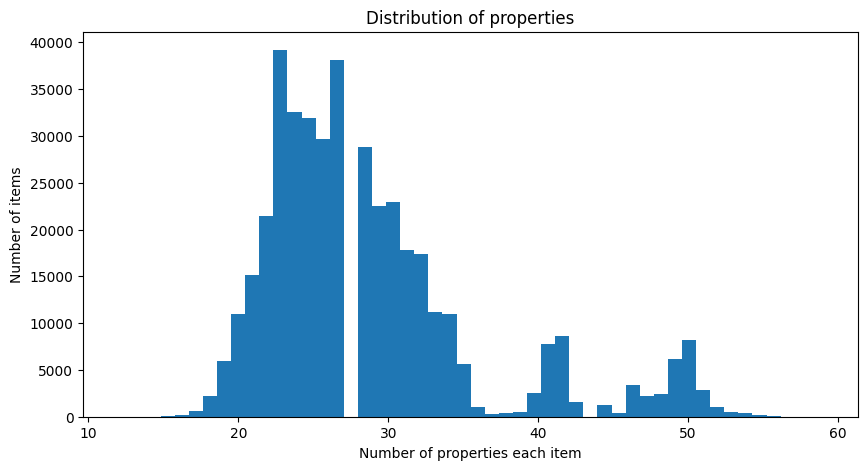

In [11]:
# số property của mỗi item
item_property_count = (
    item_df.groupby("itemid")["property"].nunique().reset_index(name="num_properties")
)
# print(item_property_count.head())
item_property_count["num_properties"].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.hist(item_property_count["num_properties"], bins=50)
plt.xlabel("Number of properties each item")
plt.ylabel("Number of items")
plt.title("Distribution of properties")
plt.show()

In [12]:
# top 30 property hiện nhiều nhất (lọc duplicate)
def plot_top_properties(count_df, top_k=20, title="Top property phổ biến", quantity=True):
    """
    count_df: DataFrame có 2 cột 'property' và 'count'
    top_k: số property muốn vẽ
    title: tiêu đề biểu đồ
    """

    # Lấy top-k từ df đã có sẵn count
    top_df = count_df.head(top_k)

    plt.figure(figsize=(14, 6))
    plt.grid(axis="y", zorder=0)

    bars = plt.bar(top_df["property"], top_df["count"], zorder=2)

    # Ghi số lên mỗi cột
    if quantity == True:
        for bar in bars:
            height = bar.get_height()

            # format lại cho dễ đọc
            if height >= 1_000_000:
                label = f"{height/1_000_000:.1f}M"
            elif height >= 1_000:
                label = f"{height/1_000:.0f}K"
            else:
                label = str(height)

            plt.text(
                bar.get_x() + bar.get_width()/2,
                height,
                label,
                ha="center", va="bottom",
                fontsize=9
            )

    plt.title(title)
    plt.xlabel("Property")
    plt.ylabel("Số lần xuất hiện")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

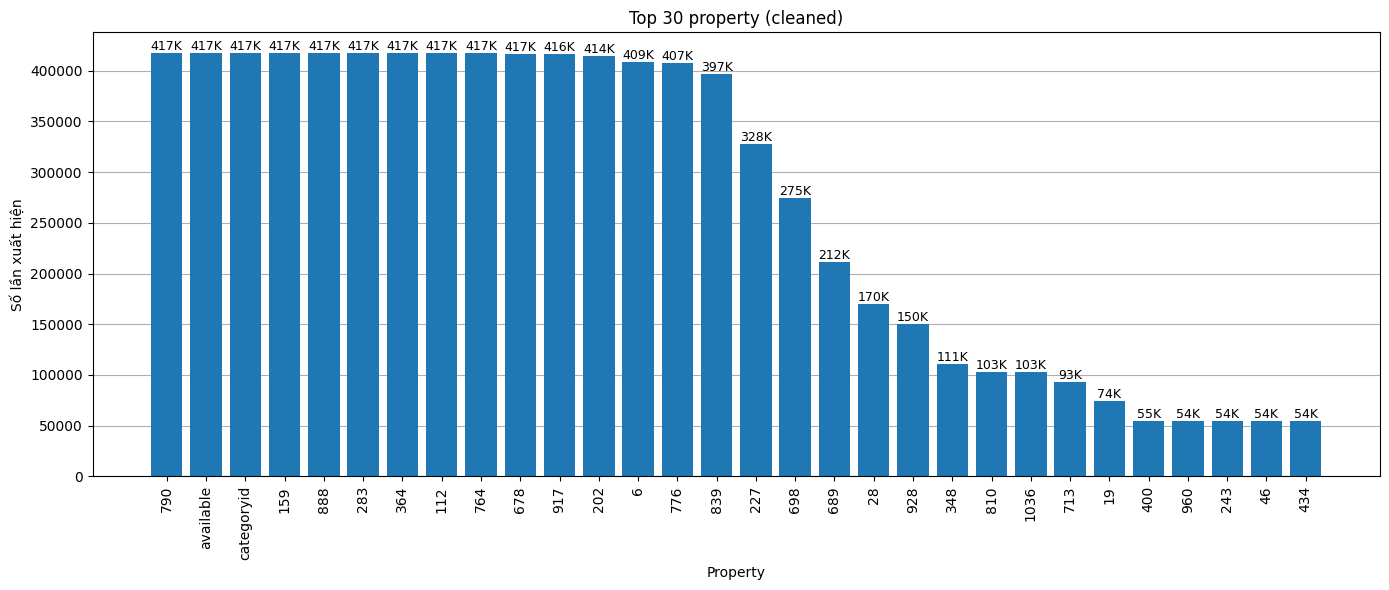

In [13]:
clean_property_df = item_df.drop_duplicates(subset=["itemid", "property"])
property_clean_counts = (
    clean_property_df["property"]
    .value_counts()
    .reset_index()
)
plot_top_properties(property_clean_counts, top_k=30, title="Top 30 property (cleaned)", quantity=True)

In [14]:
# thử show mấy cái nhiều nhất 
property_clean_counts.head(10)

,property,count
0,790,417053
1,available,417053
2,categoryid,417053
3,159,417053
4,888,417053
5,283,417053
6,364,417053
7,112,417053
8,764,417053
9,678,417019


* Checking for 417053 times appear of property

In [15]:
display(item_df[item_df["property"]=="790"])
display(item_df[item_df["property"]=="159"])
display(item_df[item_df["property"]=="888"])
display(item_df[item_df["property"]=="283"])
display(item_df[item_df["property"]=="364"])
display(item_df[item_df["property"]=="112"])
display(item_df[item_df["property"]=="764"])


,timestamp,itemid,property,value,ISO datetime,date
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
14,1434250800000,169055,790,n21000.000,2015-06-14 03:00:00,2015-06-14
16,1435460400000,178601,790,n5400.000,2015-06-28 03:00:00,2015-06-28
42,1431831600000,125874,790,n39588.000,2015-05-17 03:00:00,2015-05-17
46,1433646000000,272201,790,n10320.000,2015-06-07 03:00:00,2015-06-07
...,...,...,...,...,...,...
20275852,1433646000000,436865,790,n0.000,2015-06-07 03:00:00,2015-06-07
20275860,1437274800000,241233,790,n12048.000,2015-07-19 03:00:00,2015-07-19
20275867,1433041200000,463381,790,n0.000,2015-05-31 03:00:00,2015-05-31
20275876,1436670000000,147935,790,n42720.000,2015-07-12 03:00:00,2015-07-12


,timestamp,itemid,property,value,ISO datetime,date
21,1431226800000,344365,159,519769,2015-05-10 03:00:00,2015-05-10
22,1434250800000,269797,159,519769,2015-06-14 03:00:00,2015-06-14
74,1433646000000,126522,159,519769,2015-06-07 03:00:00,2015-06-07
214,1433646000000,400399,159,519769,2015-06-07 03:00:00,2015-06-07
227,1431226800000,238394,159,519769,2015-05-10 03:00:00,2015-05-10
...,...,...,...,...,...,...
20275691,1431226800000,145587,159,519769,2015-05-10 03:00:00,2015-05-10
20275711,1433646000000,63812,159,519769,2015-06-07 03:00:00,2015-06-07
20275736,1431226800000,125537,159,519769,2015-05-10 03:00:00,2015-05-10
20275768,1431226800000,237643,159,519769,2015-05-10 03:00:00,2015-05-10


,timestamp,itemid,property,value,ISO datetime,date
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00,2015-09-06
10,1439089200000,450113,888,1038400 45956 n504.000,2015-08-09 03:00:00,2015-08-09
17,1436670000000,319291,888,1292080,2015-07-12 03:00:00,2015-07-12
26,1435460400000,16615,888,150169 176547 824301 24474 293011 1240134,2015-06-28 03:00:00,2015-06-28
40,1433646000000,152892,888,599031,2015-06-07 03:00:00,2015-06-07
...,...,...,...,...,...,...
20275875,1439694000000,4849,888,297765 406279 907471 88645 279913 1223352 1318567,2015-08-16 03:00:00,2015-08-16
20275880,1431226800000,123846,888,72895,2015-05-10 03:00:00,2015-05-10
20275888,1434250800000,12864,888,249879 724834 1172269,2015-06-14 03:00:00,2015-06-14
20275894,1435460400000,356920,888,5135 1233825,2015-06-28 03:00:00,2015-06-28


,timestamp,itemid,property,value,ISO datetime,date
158,1434250800000,244145,283,132734 242183 797785,2015-06-14 03:00:00,2015-06-14
175,1437274800000,38494,283,1319279 920988 639039,2015-07-19 03:00:00,2015-07-19
309,1435460400000,55929,283,554317 820477 938947,2015-06-28 03:00:00,2015-06-28
334,1432436400000,439782,283,882006 768453 1113872 1230005,2015-05-24 03:00:00,2015-05-24
338,1431226800000,298072,283,341599 912235 363182 695707 479886 341599 9122...,2015-05-10 03:00:00,2015-05-10
...,...,...,...,...,...,...
20275764,1433041200000,16164,283,971154 292676 1318713 864089 215470 n13872.000,2015-05-31 03:00:00,2015-05-31
20275781,1433646000000,254983,283,305351 322391 1120576 114320 221130,2015-06-07 03:00:00,2015-06-07
20275804,1435460400000,433507,283,188678 1128577 227976 309875 486553 n48.000 31...,2015-06-28 03:00:00,2015-06-28
20275829,1435460400000,124798,283,598729 511183 981281 829153 631983,2015-06-28 03:00:00,2015-06-28


,timestamp,itemid,property,value,ISO datetime,date
73,1431226800000,206605,364,486220,2015-05-10 03:00:00,2015-05-10
100,1434250800000,403192,364,256913,2015-06-14 03:00:00,2015-06-14
134,1442113200000,182237,364,956209,2015-09-13 03:00:00,2015-09-13
178,1433041200000,82179,364,618754,2015-05-31 03:00:00,2015-05-31
230,1431226800000,179634,364,927963,2015-05-10 03:00:00,2015-05-10
...,...,...,...,...,...,...
20275533,1431226800000,441641,364,378163,2015-05-10 03:00:00,2015-05-10
20275552,1435460400000,224857,364,1307969,2015-06-28 03:00:00,2015-06-28
20275566,1431226800000,443716,364,316764,2015-05-10 03:00:00,2015-05-10
20275729,1435460400000,153544,364,369357,2015-06-28 03:00:00,2015-06-28


,timestamp,itemid,property,value,ISO datetime,date
41,1431831600000,301185,112,679677,2015-05-17 03:00:00,2015-05-17
53,1431831600000,330306,112,679677,2015-05-17 03:00:00,2015-05-17
184,1431831600000,177440,112,679677,2015-05-17 03:00:00,2015-05-17
199,1431226800000,387461,112,679677,2015-05-10 03:00:00,2015-05-10
298,1433646000000,452566,112,679677,2015-06-07 03:00:00,2015-06-07
...,...,...,...,...,...,...
20275745,1433041200000,48460,112,679677,2015-05-31 03:00:00,2015-05-31
20275777,1431226800000,391559,112,679677,2015-05-10 03:00:00,2015-05-10
20275825,1433041200000,312011,112,679677,2015-05-31 03:00:00,2015-05-31
20275881,1433041200000,167555,112,679677,2015-05-31 03:00:00,2015-05-31


,timestamp,itemid,property,value,ISO datetime,date
31,1431831600000,246186,764,1285872,2015-05-17 03:00:00,2015-05-17
67,1431831600000,462976,764,1285872,2015-05-17 03:00:00,2015-05-17
308,1431226800000,244384,764,1285872,2015-05-10 03:00:00,2015-05-10
355,1431226800000,427697,764,1285872,2015-05-10 03:00:00,2015-05-10
382,1435460400000,298812,764,1285872,2015-06-28 03:00:00,2015-06-28
...,...,...,...,...,...,...
20275595,1431226800000,211660,764,1285872,2015-05-10 03:00:00,2015-05-10
20275605,1435460400000,130689,764,1285872,2015-06-28 03:00:00,2015-06-28
20275611,1431226800000,140096,764,1285872,2015-05-10 03:00:00,2015-05-10
20275728,1435460400000,87022,764,1285872,2015-06-28 03:00:00,2015-06-28


#### Category

In [16]:
display(category_df.head())
print(category_df.info())
# print(category_df[['property']].value_counts())

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB
None


In [17]:
roots = category_df[category_df['parentid'].isna()]['categoryid']
print("Number of root category: " + str(len(roots)))
display(category_df[category_df['parentid'].isna()].head())
print("Number of duplicated category: ")
category_df[category_df.duplicated(subset=['categoryid'], keep=False)] # no duplicate category_id

Number of root category: 25


,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN


Number of duplicated category: 


,categoryid,parentid


In [18]:
# check xem có category nào có nhiều parent đồng cấp không
multi_parent = (
    category_df
    .dropna(subset=['parentid'])
    .groupby('categoryid')['parentid']
    .nunique()
)

print(f"Number of categories have multi-parents: {multi_parent[multi_parent > 1].__len__()}")


Number of categories have multi-parents: 0


In [19]:
def build_tree(df=category_df):
    # create node map
    nodes = {}
    for _, r in df.iterrows():
        cid = int(r["categoryid"])
        nodes[cid] = {
            "name": str(cid),
            "children": []
        }

    roots = []

    for _, r in df.iterrows():
        cid = int(r["categoryid"])
        pid = r["parentid"]

        if pd.isna(pid):
            roots.append(nodes[cid])
        else:
            nodes[int(pid)]["children"].append(nodes[cid])

    # nếu nhiều root → tạo super root
    if len(roots) == 1:
        return roots[0]
    else:
        return {
            "name": "ROOT",
            "children": roots
        }


tree_data = build_tree(category_df)

# ==== SAVE JSON ====
with open("../dataset/category_tree.json", "w", encoding="utf-8") as f:
    json.dump(tree_data, f, ensure_ascii=False, indent=2)

print("category_tree.json generated")


category_tree.json generated


In [25]:
def build_category_sparse_tree(
    df,
    keep_ratio=0.5,
    min_children=1,
    random_seed=42
):
    """
    Build sparse category tree for visualization.

    Rules:
    - ROOT giả (depth=0): giữ 100%
    - Tất cả các tầng thực (depth >= 1): giữ keep_ratio (mặc định 0.5)
    """

    random.seed(random_seed)

    # ---------- build adjacency ----------
    children_map = defaultdict(list)
    parent_map = {}

    for _, r in df.iterrows():
        cid = int(r["categoryid"])
        pid = r["parentid"]

        parent_map[cid] = None if pd.isna(pid) else int(pid)
        if not pd.isna(pid):
            children_map[int(pid)].append(cid)

    # ---------- find roots ----------
    roots = [cid for cid, pid in parent_map.items() if pid is None]

    # ---------- recursive sparse build ----------
    def build_node(cid, depth):
        node = {
            "name": str(cid),
            "children": []
        }

        children = children_map.get(cid, [])
        if not children:
            return node

        # ROOT giả: giữ toàn bộ
        if depth == 0:
            kept_children = children

        # Các tầng thực: giữ theo ratio
        else:
            k = max(min_children, int(len(children) * keep_ratio))
            k = min(k, len(children))
            kept_children = random.sample(children, k)

        for child in kept_children:
            node["children"].append(build_node(child, depth + 1))

        return node

    # ---------- handle multiple roots ----------
    if len(roots) == 1:
        # 1 root thật → ROOT giả không cần
        return build_node(roots[0], 1)

    else:
        # nhiều root → ROOT giả
        return {
            "name": "ROOT",
            "children": [build_node(r, 1) for r in roots]
        }


# ===== BUILD TREE =====
sparse_tree_data = build_category_sparse_tree(
    category_df,
    keep_ratio=0.5,
    min_children=1
)

# ===== SAVE JSON =====
with open("../dataset/category_sparse_tree.json", "w", encoding="utf-8") as f:
    json.dump(sparse_tree_data, f, ensure_ascii=False, indent=2)

print("category_sparse_tree.json generated")

category_sparse_tree.json generated


## Data cho K-means

## RFM-CLV
